# Importing Libraries

In [ ]:
## Import Libraries
#! pip install optuna
! pip install attention

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import logging
import sys

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from attention import Attention
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import optuna
from sklearn.model_selection import StratifiedKFold

from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

from sklearn.metrics import f1_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

random = 14

# Import and Preprocess Datasets

1. Read `train_augmented_synonym.csv` and `test.csv` that are created prior to this notebook.
    - `train_augmented_synonym.csv` is a training set created from splitted train data, in which minority target values are duplicated where parts of words are replaced with synonyms.
    - Target values are already forced to binary.
2. Perform Exploratory Data Analysis.
3. Perform text preprocessing: Lower Casing, Counting number of words etc.
4. Tokenizing and Padding Text Data.

In [2]:
## Dataset Paths
path = '/kaggle/input/cs3244-lstm/'
train_path = f'{path}train_augmented_synonym.csv'
test_path = f'{path}test_aug.csv'

In [3]:
## Reading Datasets
D = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## Exploratory Data Analysis

In [ ]:
## Checking Null Entries
print("Number of Null Data: " + str(D.isnull().sum().sum()))

## Checking Dimensions
print("Number of Variables: ")
print(D.shape[1])
print("\nNumber of Data Points: ")
print(D.shape[0])

## Structure of the Dataset
D.head()

In [ ]:
## Checks for Creating New Dependent Variable
def analyze_var(df, col_list):
    col_list_v = col_list[1:]
    res = pd.DataFrame(col_list_v)
    for dv in col_list_v:
        count = []
        D_dv = D.loc[D[dv]==1]
        for dv2 in col_list_v:
            D_dv_dv2 = D_dv.loc[D_dv[dv2]==1]
            count.append(D_dv_dv2.shape[0])
        res = pd.concat([res,pd.DataFrame(count)],axis=1)
    res.columns = col_list
    return res

analyze_var(D, ['var_count','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [ ]:
## Distribution of Dependent Variable - Malignant
sns.countplot(data = D, x= 'malignant')
print("Number of Non-Malignant Comments: {0}".format(sum(D['malignant'] == 0)))
print("Number of Malignant Comments: {0}".format(sum(D['malignant'] == 1)))

## Preprocessing and Feature Extraction

Puncuations that are found to express emotions in chats are counted separately once again. Those punctuations are chosen from the sources below:

1. "The interactional principle in digital punctuation": https://www.sciencedirect.com/science/article/pii/S2211695821000180
2. "Punctuation is the New Measure of Emotion": https://ericadhawan.medium.com/punctuation-is-the-new-measure-of-emotion-329b684743f0

In [4]:
## Text Feature Extraction - D

#### Make Strings to Lower Case
D['comment_text'] = D['comment_text'].str.lower()

#### Keep Track of String's Original Length
D['length'] = D['comment_text'].str.len()

#### Replace Email Address with 'email'
D['comment_text'] = D['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

#### Replace Website Address with 'website'
D['comment_text'] = D['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

#### Replace Website Address with 'phonenumber'
D['comment_text'] = D['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

#### Replace Numbers with 'numbrs'
D['comment_text'] = D['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

#### Special Punctuations are Replaced Explicitly.
D['comment_text'] = D['comment_text'].str.replace(r'!',' exclamationmark')
D['comment_text'] = D['comment_text'].str.replace(r'\?',' questionmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{1}',' periodmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
D['comment_text'] = D['comment_text'].str.replace(r'£|\$', ' dollers')

## Removing Leftover Punctuations
def remove_punct(text):
    p_free="".join([i for i in text if i not in string.punctuation])
    return p_free
D['comment_text'] = D['comment_text'].apply(lambda x:remove_punct(x))

In [5]:
## Text Pre-Processing - Test

#### Make Strings to Lower Case
test['comment_text'] = test['comment_text'].str.lower()

#### Keep Track of String's Original Length
test['length'] = test['comment_text'].str.len()

#### Replace Email Address with 'email'
test['comment_text'] = test['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

#### Replace Website Address with 'website'
test['comment_text'] = test['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

#### Replace Website Address with 'phonenumber'
test['comment_text'] = test['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

#### Replace Numbers with 'numbrs'
test['comment_text'] = test['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

#### Special Punctuations are Replaced Explicitly.
test['comment_text'] = test['comment_text'].str.replace(r'!',' exclamationmark')
test['comment_text'] = test['comment_text'].str.replace(r'\?',' questionmark')
test['comment_text'] = test['comment_text'].str.replace(r'\.{1}',' periodmark')
test['comment_text'] = test['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
test['comment_text'] = test['comment_text'].str.replace(r'£|\$', ' dollers')

## Removing Leftover Punctuations
def remove_punct(text):
    p_free="".join([i for i in text if i not in string.punctuation])
    return p_free
test['comment_text'] = test['comment_text'].apply(lambda x:remove_punct(x))

In [8]:
## Tokenizing Strings
X_train = D['comment_text']
y_train = D['malignant']
X_test = test['comment_text']
y_test = test['malignant']

train_text = X_train.fillna("_na_").values
test_text = X_test.fillna("_na_").values

max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text))
tokenized_train = tokenizer.texts_to_sequences(train_text)
tokenized_test = tokenizer.texts_to_sequences(test_text)

In [ ]:
print("Number of observations in X_train: {}".format(X_train.shape[0]))
print("Number of observations in X_test: {}".format(X_test.shape[0]))

In [ ]:
## Distribution of Number of Words.
totalNumWords = [len(text) for text in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title('Histogram of Document Length')
plt.ylabel('Document Frequency')
plt.xlabel('Document Length')
plt.show()

In [9]:
## Pad the Tokenized List - Evening Length
maxlen = 150
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

## Building and Training Model - LSTM on Synonym Augmented Data

In [ ]:
def build_lstm(hp, maxlen, max_features, X, y):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, hp['embed_size'])(inp)
    x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
    if hp['attention'] == 1:
        x = Attention(units=hp['attention_units'])(x)
    else:
        x = GlobalMaxPool1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(hp['dropout'])(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.5, random_state=random)
    model.fit(X_t, y_t, epochs=hp['epochs'], batch_size=hp['batch_size'])
    y_pred = model.predict([X_v], batch_size=256, verbose=1)
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_v, y_pred, average = 'macro')
    return model, score#np.mean(scores)

def build_lstm_cv(hp, maxlen, max_features, X, y, cv):
    scores = []
    skf = StratifiedKFold(n_splits=cv)
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        inp = Input(shape=(maxlen, ))
        x = Embedding(max_features, hp['embed_size'])(inp)
        if hp['bidirectional'] == 1:
            x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
        else:
            x = LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0)(x)
        if hp['attention'] == 1:
            x = Attention(units=hp['attention_units'])(x)
        else:
            x = GlobalMaxPool1D()(x)
        x = Dense(50, activation='relu')(x)
        x = Dropout(hp['dropout'])(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', 
                      optimizer=optimizers.Adam(), 
                      metrics=['accuracy'])
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_true = y[test_index]
        model.fit(X_train, y_train, epochs=hp['epochs'], batch_size=hp['batch_size'])
        gc.collect()
        y_pred = model.predict([X_test], batch_size=256, verbose=1)
        y_pred = (y_pred > 0.5).astype(int)
        scores.append(f1_score(y_true, y_pred, average = 'macro'))
        gc.collect()
        # You can add something here if you want to keep track of cv scores independently.
    return model, np.mean(scores)
        
def objective(trial, maxlen, max_features, X, y, cv, apply_cv = False):
    hp = {
        'embed_size': trial.suggest_int('embed_size', 64, 256, step = 64),
        'op_lstm_size': trial.suggest_int('op_lstm_size', 50, 60),
        'dropout_lstm': trial.suggest_float('dropout_lstm', 0, 0.5),
        'dropout': trial.suggest_float('dropout', 0, 0.5),
        'epochs': trial.suggest_int('epochs', 2, 5),
        'batch_size': trial.suggest_categorical('batch_size', [128,256,512,1024]),
        'attention': trial.suggest_categorical('attention', [0,1]),
        'attention_units': trial.suggest_categorical('attention_units', [16,32,64]),
        'bidirectional': trial.suggest_categorical('bidirectional', [0,1])
    }
    
    model, f1macro = build_lstm(hp, maxlen, max_features, X, y)

    return f1macro

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "cs3244-lstm-study-f1_macro" 
storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
#import os
#os.system('rm /kaggle/working/cs3244-lstm-study-f1_macro.csv')
#os.system('cp /kaggle/input/cs3244-lstm/cs3244-lstm-study.db /kaggle/working/cs3244-lstm-study.db')

In [ ]:
cv = 5
study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=SuccessiveHalvingPruner(),
                           study_name=study_name, storage=storage_name, load_if_exists=True)
func = lambda trial: objective(trial, maxlen, max_features, X_train, y_train, cv, apply_cv = False)
study.optimize(func, n_trials=100, gc_after_trial=True)

In [ ]:
study.trials_dataframe().to_csv("/kaggle/working/cs3244-lstm-study-f1_macro.csv")
study.trials_dataframe()

In [ ]:
## Loading Saved Outputs
augmented_res_path = f'{path}augmented_data_tuning.csv'
augmented_res = pd.read_csv(original_res_path)[['value', 'params_attention', 'params_attention_units', 'params_batch_size', 
                                               'params_bidirectional', 'params_dropout', 'params_dropout_lstm', 'params_embed_size', 
                                               'params_epochs', 'params_op_lstm_size']]

In [ ]:
## Best Parameter for LSTM
best_param = augmented_res[augmented_res['value'] == np.max(augmented_res['value'])].reset_index()
best_param.columns = ['index', 'value', 'attention', 'attention_units', 
                      'batch_size', 'bidirectional', 'dropout', 'dropout_lstm', 
                      'embed_size', 'epochs', 'op_lstm_size']

The resulting best parameters for LSTM model trained on original dataset is:
* Attention: No Attention used.
* batch_size: 128
* bidirectional: No Bidirectional.
* dropout: 0.416
* dropout_lstm: 0.010
* embed_size = 256
* epochs = 3
* op_lstm_size = 60
* threshold_value = 0.55

The Final Test Score on Test Set is:
* Accuracy: 0.95
* F1-Macro Score: 0.8481

In [10]:
D_augs = []
Ds = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    temp_path = f'{path}D_CV_{i}.csv'
    temp_aug_path = f'{path}D_CV_{i}_aug.csv'
    D_temp = pd.read_csv(temp_path)
    D_aug_temp = pd.read_csv(temp_aug_path)
    Ds.append(D_temp)
    D_augs.append(D_aug_temp)

In [11]:
X_ts = []
y_ts = []
X_vs = []
y_vs = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    D_temp = pd.DataFrame()
    for j in [0,1,2,3,4,5,6,7,8,9]:
        if j != i:
            D_temp = pd.concat([D_temp, D_augs[j]],axis=0)
    X_ts.append(D_temp['comment_text'])
    y_ts.append(D_temp['malignant'])
    D_temp = Ds[i]
    X_vs.append(D_temp['comment_text'])
    y_vs.append(D_temp['malignant'])

In [12]:
for i in [0,1,2,3,4,5,6,7,8,9]:
    X_t = X_ts[i]
    X_t = X_t.fillna("_na_").values
    X_t = tokenizer.texts_to_sequences(X_t)
    X_t = pad_sequences(X_t, maxlen=maxlen)
    X_ts[i] = X_t
    X_v = X_vs[i]
    X_v = X_v.fillna("_na_").values
    X_v = tokenizer.texts_to_sequences(X_v)
    X_v = pad_sequences(X_v, maxlen=maxlen)
    X_vs[i] = X_v

In [13]:
scores = []

In [15]:
hp = {'embed_size': 256, 
 'op_lstm_size': 60, 
 'dropout_lstm': 0.010001815426642857, 
 'dropout': 0.4164505274315438, 
 'epochs': 3, 
 'batch_size': 128, 
 'attention': 0, 
 'attention_units': 32, 
 'bidirectional': 0}

for i in [0,1,2,3,4,5,6,7,8,9]:
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, hp['embed_size'])(inp)
    x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
    if hp['attention'] == 1:
        x = Attention(units=hp['attention_units'])(x)
    else:
        x = GlobalMaxPool1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(hp['dropout'])(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    
    X_t = X_ts[i]
    y_t = y_ts[i]
    X_v = X_vs[i]
    y_v = y_vs[i]
    model.fit(X_t, y_t, epochs=3, batch_size=128)
    y_pred = model.predict([X_v], batch_size=256, verbose=1)
    score = []
    for thresh in np.arange(0,1.01,0.05):
        y_thresh = (y_pred > thresh).astype(int)
        score.append(f1_score(y_v, y_thresh, average = 'macro'))
    scores.append(score)

Epoch 1/3
1970/1970 [==============================] - 54s 23ms/step - loss: 0.1531 - accuracy: 0.9387
Epoch 2/3
1970/1970 [==============================] - 46s 23ms/step - loss: 0.0819 - accuracy: 0.9692
Epoch 3/3
62/62 [==============================] - 1s 11ms/step
Epoch 1/3
1970/1970 [==============================] - 50s 24ms/step - loss: 0.1580 - accuracy: 0.9380
Epoch 2/3
1970/1970 [==============================] - 46s 23ms/step - loss: 0.0855 - accuracy: 0.9684
Epoch 3/3
62/62 [==============================] - 1s 11ms/step
Epoch 1/3
1970/1970 [==============================] - 50s 24ms/step - loss: 0.1522 - accuracy: 0.9401
Epoch 2/3
1970/1970 [==============================] - 47s 24ms/step - loss: 0.0806 - accuracy: 0.9699
Epoch 3/3
62/62 [==============================] - 2s 10ms/step
Epoch 1/3
1978/1978 [==============================] - 50s 23ms/step - loss: 0.1598 - accuracy: 0.9365
Epoch 2/3
1978/1978 [==============================] - 46s 23ms/step - loss: 0.0866 - a

In [16]:
#pd.DataFrame(scores).to_csv("/kaggle/working/threshold_scores_augmented.csv")

In [17]:
threshold_path = f'{path}threshold_scores_augmented.csv'
threshold_scores = pd.read_csv(threshold_path)

In [18]:
scores = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    score = np.array((threshold_scores[threshold_scores['Unnamed: 0']==i]))[0][1:22]
    scores.append(score)

In [19]:
avg_score = (np.array(scores[0]) + np.array(scores[1]) + np.array(scores[2]) + np.array(scores[3]) + np.array(scores[4]) + np.array(scores[5]) + np.array(scores[6]) + np.array(scores[7]) + np.array(scores[8]) + np.array(scores[9]))/10
best_threshold = np.arange(0,1.01,0.05)[avg_score == np.max(avg_score)][0]

In [20]:
best_threshold

0.55

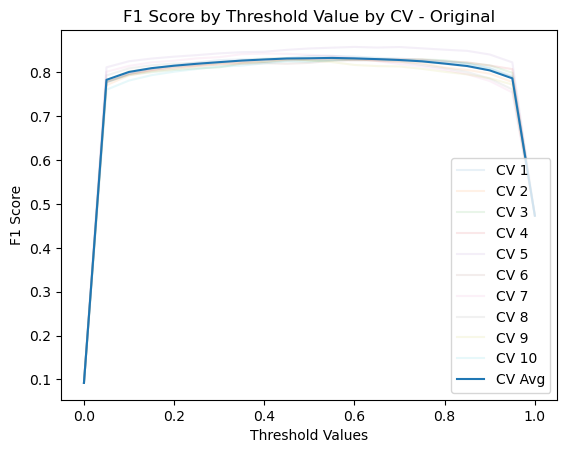

In [21]:
## F1 Macro Scores by Threshold
thresholds = np.arange(0,1.01,0.05)
plt.plot(thresholds,scores[0], alpha=0.1)
plt.plot(thresholds,scores[1], alpha=0.1)
plt.plot(thresholds,scores[2], alpha=0.1)
plt.plot(thresholds,scores[3], alpha=0.1)
plt.plot(thresholds,scores[4], alpha=0.1)
plt.plot(thresholds,scores[5], alpha=0.1)
plt.plot(thresholds,scores[6], alpha=0.1)
plt.plot(thresholds,scores[7], alpha=0.1)
plt.plot(thresholds,scores[8], alpha=0.1)
plt.plot(thresholds,scores[9], alpha=0.1)
plt.plot(thresholds,avg_score)
plt.title('F1 Score by Threshold Value by CV - Original')
plt.ylabel('F1 Score')
plt.xlabel('Threshold Values')
plt.legend(['CV 1', 'CV 2','CV 3','CV 4', 'CV 5', 'CV 6', 'CV 7', 'CV 8', 'CV 9', 'CV 10', 'CV Avg'], loc='lower right')
plt.show()

In [22]:
## LSTM CI from CV Results
cv_f1_score_lstm = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    f1_cv = scores[i][np.arange(0,1.01,0.05)==best_threshold]
    cv_f1_score_lstm.append(f1_cv[0])
lstm_mean = np.mean(cv_f1_score_lstm)
lstm_std = np.std(cv_f1_score_lstm)
lstm_ci = [lstm_mean - 3*lstm_std, lstm_mean + 3*lstm_std] ## Includes 99.7% numbers around est. mean.

In [23]:
print("Mean CV Score: {}".format(lstm_mean))
print("Standard Deviation CV Score: {}".format(lstm_std))

Mean CV Score: 0.8331013335678428
Standard Deviation CV Score: 0.008917927912817952


In [24]:
lstm_ci

[0.8063475498293889, 0.8598551173062966]

In [25]:
## Final Test on Test Data
hp = {'embed_size': 256, 
 'op_lstm_size': 60, 
 'dropout_lstm': 0.010001815426642857, 
 'dropout': 0.4164505274315438, 
 'epochs': 3, 
 'batch_size': 128, 
 'attention': 0, 
 'attention_units': 32, 
 'bidirectional': 0}
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, hp['embed_size'])(inp)
x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
if hp['attention'] == 1:
    x = Attention(units=hp['attention_units'])(x)
else:
    x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(hp['dropout'])(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=128)
y_pred = model.predict([X_test], batch_size=256, verbose=1)
y_pred = (y_pred > best_threshold).astype(int)
print('[LSTM] F1 Macro score is {}'.format(f1_score(y_test, y_pred, average = 'macro')))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Epoch 1/3
2198/2198 [==============================] - 56s 24ms/step - loss: 0.1276 - accuracy: 0.9513
Epoch 2/3
2198/2198 [==============================] - 51s 23ms/step - loss: 0.0715 - accuracy: 0.9733
Epoch 3/3
262/262 [==============================] - 3s 10ms/step
[LSTM] F1 Macro score is 0.848138551643406
[[58850  1579]
 [ 1960  4676]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     60429
           1       0.75      0.70      0.73      6636

    accuracy                           0.95     67065
   macro avg       0.86      0.84      0.85     67065
weighted avg       0.95      0.95      0.95     67065

